In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the Dataset

In [2]:
import pandas as pd

# Load the data
file_path = '/content/drive/My Drive/AMZN.csv'
df = pd.read_csv(file_path)

# Display the first few rows
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,"Oct 2, 2024",184.44,186.60,184.04,184.76,184.76,"23,664,500"
1,"Oct 1, 2024",184.9,186.19,183.45,185.13,185.13,"36,044,900"
2,"Sep 30, 2024",187.14,188.49,184.65,186.33,186.33,"41,583,900"
3,"Sep 27, 2024",190.68,190.90,187.34,187.97,187.97,"36,002,300"
4,"Sep 26, 2024",194.31,194.53,189.54,191.16,191.16,"36,334,900"


# Data Preprocessing

In [3]:
# Convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the Date as the index
df.set_index('Date', inplace=True)

# Handle missing values if any
df.fillna(method='ffill', inplace=True)

# Display summary statistics
df.describe()


<ipython-input-3-72ebc25c832c>:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


,High,Low,Close,Adj Close
count,6895.000000,6895.000000,6895.000000,6895.000000
mean,38.730922,37.791051,38.271604,38.271604
std,55.401283,54.099554,54.756555,54.756555
min,0.070000,0.070000,0.070000,0.070000
25%,2.130000,2.050000,2.085000,2.085000
50%,8.890000,8.690000,8.800000,8.800000
75%,57.985000,56.650000,57.350000,57.350000
max,201.200000,199.050000,200.000000,200.000000


# Data Visualization

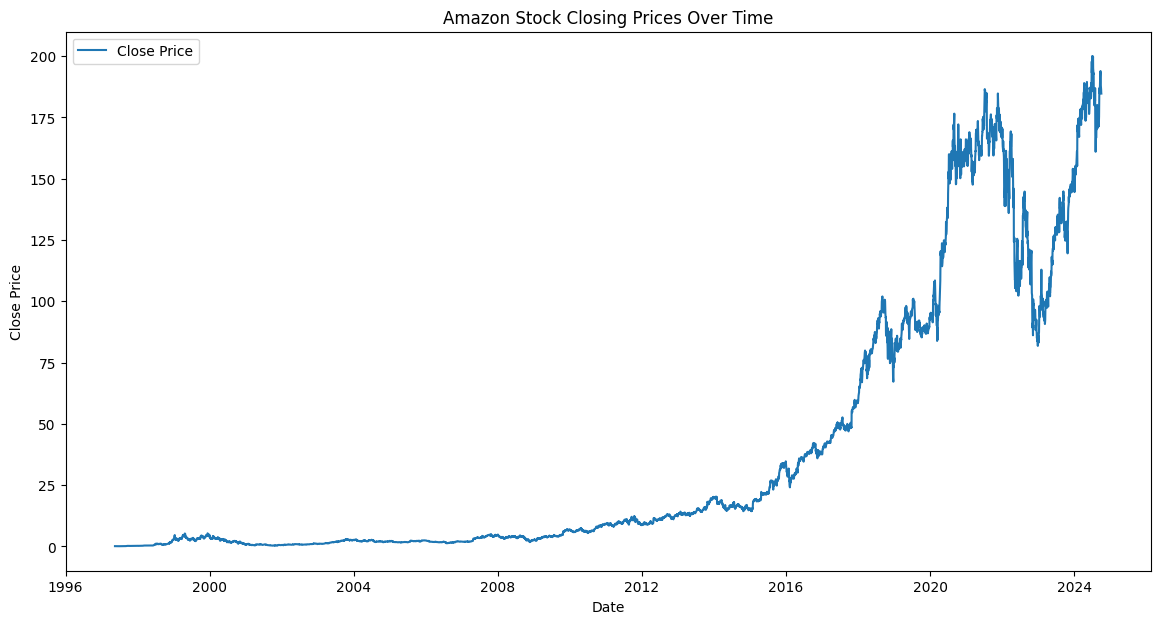

In [4]:
import matplotlib.pyplot as plt

# Plot closing price over time
plt.figure(figsize=(14,7))
plt.plot(df['Close'], label='Close Price')
plt.title('Amazon Stock Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


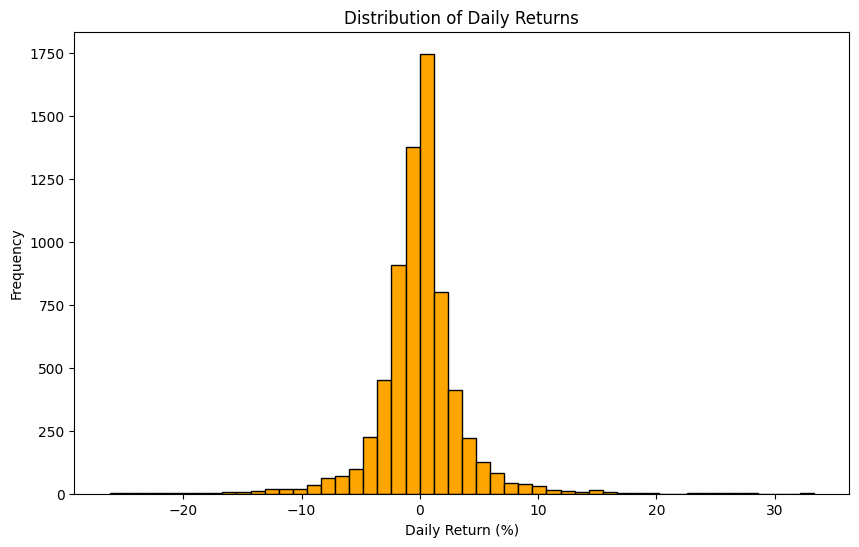

In [8]:
# Calculate daily returns
df['Daily_Return'] = df['Close'].pct_change() * 100

# Plot histogram of daily returns
plt.figure(figsize=(10, 6))
plt.hist(df['Daily_Return'].dropna(), bins=50, color='orange', edgecolor='black')
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return (%)')
plt.ylabel('Frequency')
plt.show()


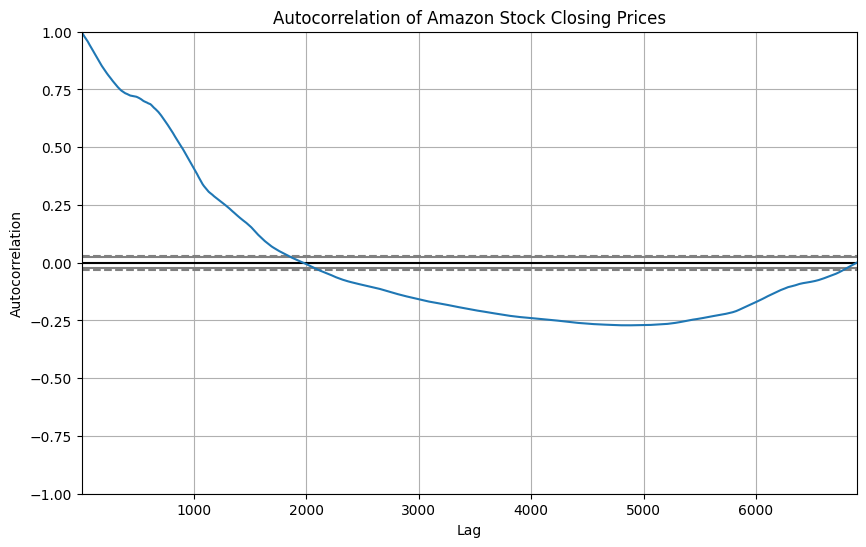

In [10]:
from pandas.plotting import autocorrelation_plot

# Autocorrelation plot of closing price
plt.figure(figsize=(10, 6))
autocorrelation_plot(df['Close'])
plt.title('Autocorrelation of Amazon Stock Closing Prices')
plt.show()


# Split the Data

In [16]:
from sklearn.model_selection import train_test_split

# Define features and target
features = ['Open', 'High', 'Low', 'Close', 'Volume']
target = 'Close'

# Split data (80% train, 20% test)
train_data, test_data = train_test_split(df[features], test_size=0.2, shuffle=False)


# Statistical Model - ARIMA

<ipython-input-40-a571b26315a5>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df['Close'].resample('M').mean()  # Using monthly data as an example


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1878.813, Time=3.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1883.718, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1883.094, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1883.502, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1885.014, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1880.086, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1882.179, Time=0.28 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1885.856, Time=0.48 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1879.999, Time=0.94 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1883.124, Time=0.24 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1880.667, Time=0.40 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1882.234, Time=0.32 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1881.856, Time=1.16 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1879.544, Time=0.29 sec

Best model:  ARIMA(2,1,2)(0,0,0)

<ipython-input-40-a571b26315a5>:36: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=forecast_start, periods=extended_forecast_steps, freq='M')


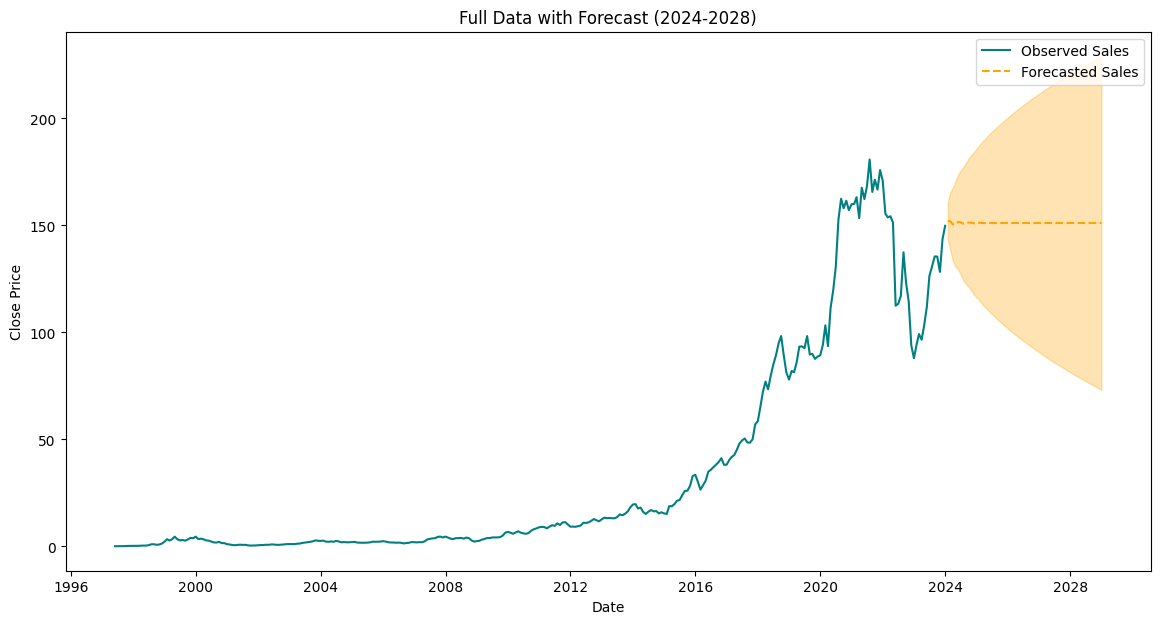

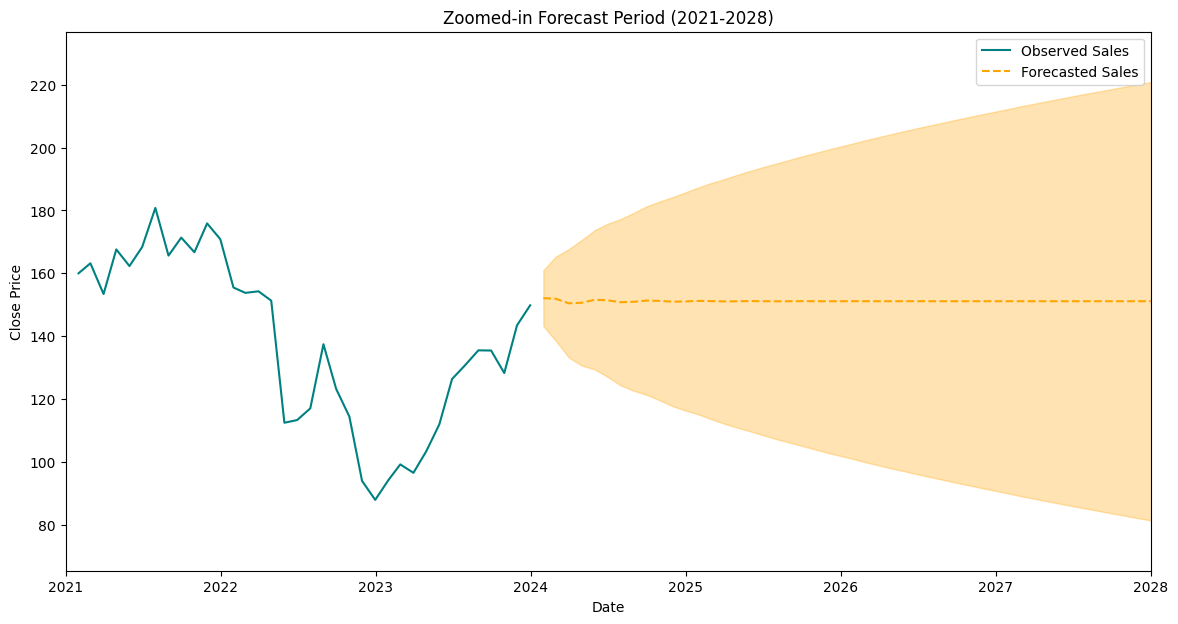

In [40]:
# Import necessary libraries
from pmdarima import auto_arima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA



# Convert daily data to monthly if needed
df_monthly = df['Close'].resample('M').mean()  # Using monthly data as an example

# Choose the data to proceed with (e.g., monthly data)
data = df_monthly

# Split the data into training and test sets
train_data = data[data.index < '2024-01-01']
test_data = data[data.index >= '2024-01-01']  # Start forecasting after the last training point

# Use auto_arima to find the best p, d, q values
auto_model = auto_arima(train_data, seasonal=False, trace=True, stepwise=True)
print(auto_model.summary())

# Get the optimal order and use it in the ARIMA model
best_order = auto_model.order
arima_model = ARIMA(train_data, order=best_order)
arima_model_fit = arima_model.fit()

# Forecast for an extended period (e.g., up to the end of 2028)
extended_forecast_steps = 60  # 60 months (5 years) from 2024, adjust as needed
arima_forecast = arima_model_fit.forecast(steps=extended_forecast_steps)

# Generate dates for the forecasted values
forecast_start = pd.to_datetime(test_data.index[0])  # Ensure forecast_start is a datetime object
forecast_index = pd.date_range(start=forecast_start, periods=extended_forecast_steps, freq='M')

# Calculate confidence intervals for the forecast
conf_int = arima_model_fit.get_forecast(steps=extended_forecast_steps).conf_int()

# Plot 1: Full data with extended forecast
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data, label='Observed Sales', color='teal')
plt.plot(forecast_index, arima_forecast, color='orange', linestyle='--', label='Forecasted Sales')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='orange', alpha=0.3)
plt.title('Full Data with Forecast (2024-2028)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Plot 2: Zoomed-in view of the forecast period only
plt.figure(figsize=(14, 7))
plt.plot(train_data.index[-36:], train_data[-36:], label='Observed Sales', color='teal')  # Show recent data only
plt.plot(forecast_index, arima_forecast, color='orange', linestyle='--', label='Forecasted Sales')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='orange', alpha=0.3)
plt.xlim([pd.to_datetime('2021-01-01'), pd.to_datetime('2028-01-01')])  # Ensure the date limits are datetime objects
plt.title('Zoomed-in Forecast Period (2021-2028)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


# Sarima

<ipython-input-41-c9eb30fc6a7f>:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df['Close'].resample('M').mean()  # Using monthly data as an example


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1877.537, Time=3.75 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1883.718, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1883.859, Time=0.32 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1884.475, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1885.014, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=1880.025, Time=1.18 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=1879.775, Time=1.50 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=1877.806, Time=9.59 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=1877.516, Time=4.64 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=1875.516, Time=3.33 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=1876.426, Time=4.47 sec
 ARIMA(2,1,1)(0,0,2)[12] intercept   : AIC=1877.553, Time=2.77 sec
 ARIMA(3,1,2)(0,0,2)[12] intercept   : AIC=1880.372, Time=2.79 sec
 ARIMA(2,1,3)(0,0,2)[12] intercept   : AIC=1877.390, Time=14.93 sec
 ARIMA(1,1,1)(0,0,

<ipython-input-41-c9eb30fc6a7f>:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=forecast_start, periods=extended_forecast_steps, freq='M')


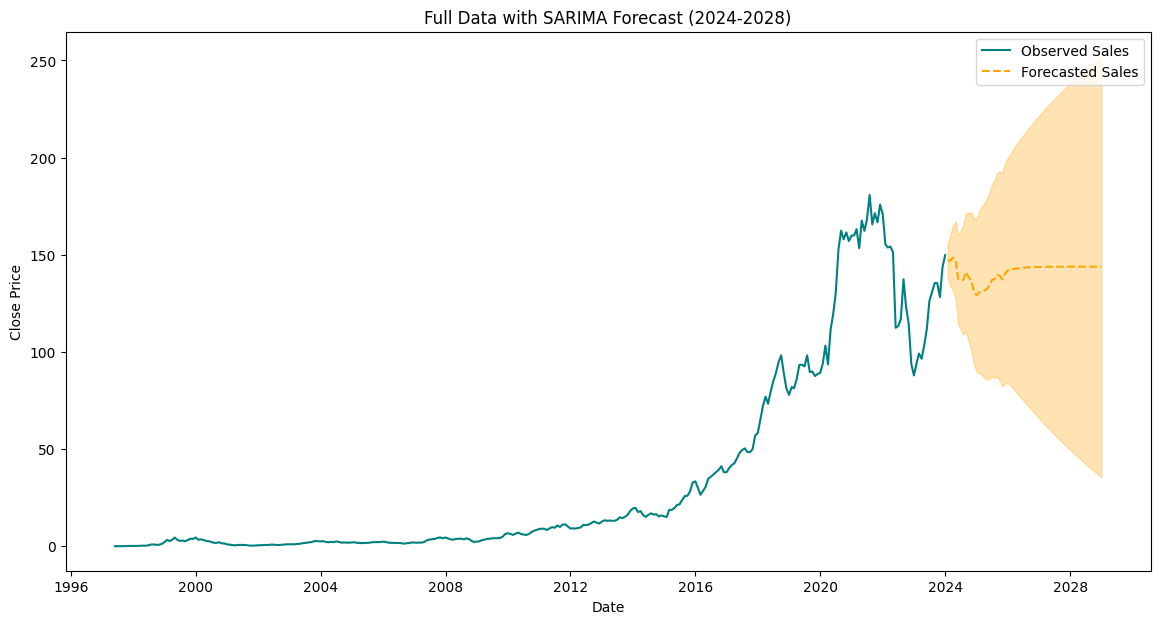

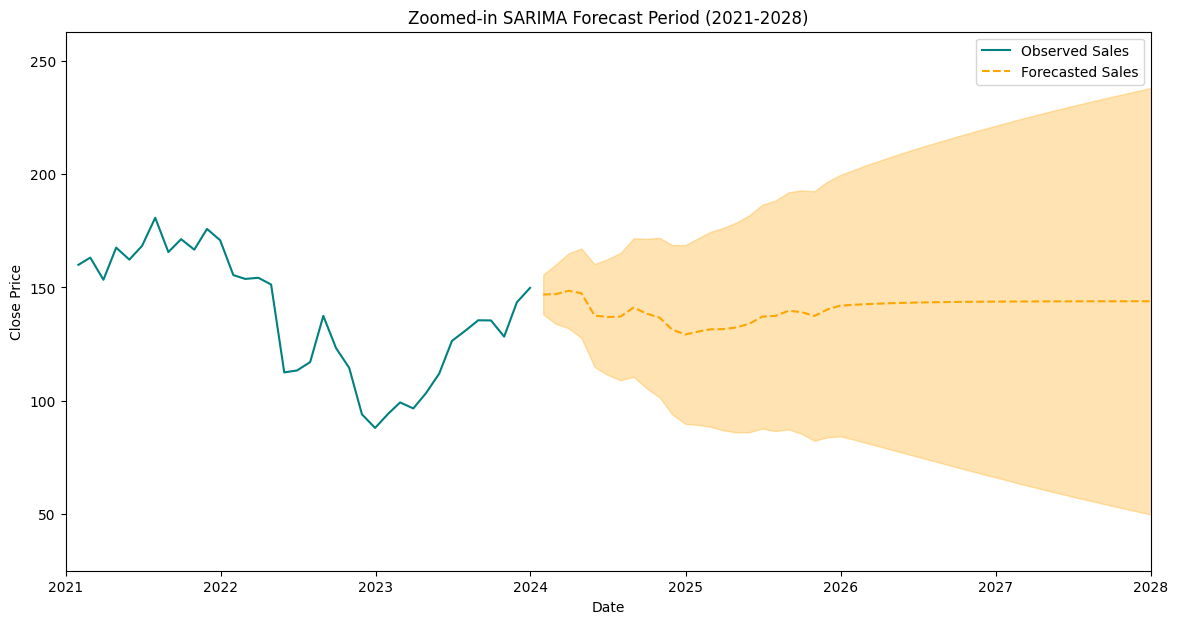

In [41]:
# Import necessary libraries
from pmdarima import auto_arima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Convert daily data to monthly if needed
df_monthly = df['Close'].resample('M').mean()  # Using monthly data as an example

# Choose the data to proceed with (e.g., monthly data)
data = df_monthly

# Split the data into training and test sets
train_data = data[data.index < '2024-01-01']
test_data = data[data.index >= '2024-01-01']  # Start forecasting after the last training point

# Use auto_arima to find the best p, d, q, P, D, Q values with seasonality
auto_model = auto_arima(train_data, seasonal=True, m=12, trace=True, stepwise=True)
print(auto_model.summary())

# Get the optimal order and seasonal order
best_order = auto_model.order
best_seasonal_order = auto_model.seasonal_order
sarima_model = SARIMAX(train_data, order=best_order, seasonal_order=best_seasonal_order)
sarima_model_fit = sarima_model.fit()

# Forecast for an extended period (e.g., up to the end of 2028)
extended_forecast_steps = 60  # 60 months (5 years) from 2024, adjust as needed
sarima_forecast = sarima_model_fit.forecast(steps=extended_forecast_steps)

# Generate dates for the forecasted values
forecast_start = pd.to_datetime(test_data.index[0])  # Ensure forecast_start is a datetime object
forecast_index = pd.date_range(start=forecast_start, periods=extended_forecast_steps, freq='M')

# Calculate confidence intervals for the forecast
conf_int = sarima_model_fit.get_forecast(steps=extended_forecast_steps).conf_int()

# Plot 1: Full data with extended forecast
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data, label='Observed Sales', color='teal')
plt.plot(forecast_index, sarima_forecast, color='orange', linestyle='--', label='Forecasted Sales')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='orange', alpha=0.3)
plt.title('Full Data with SARIMA Forecast (2024-2028)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Plot 2: Zoomed-in view of the forecast period only
plt.figure(figsize=(14, 7))
plt.plot(train_data.index[-36:], train_data[-36:], label='Observed Sales', color='teal')  # Show recent data only
plt.plot(forecast_index, sarima_forecast, color='orange', linestyle='--', label='Forecasted Sales')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='orange', alpha=0.3)
plt.xlim([pd.to_datetime('2021-01-01'), pd.to_datetime('2028-01-01')])  # Ensure the date limits are datetime objects
plt.title('Zoomed-in SARIMA Forecast Period (2021-2028)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()


# FBProphet

DEBUG:cmdstanpy:input tempfile: /tmp/tmpuqqfvj6s/ioz2zzmd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuqqfvj6s/cda4pd27.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17690', 'data', 'file=/tmp/tmpuqqfvj6s/ioz2zzmd.json', 'init=/tmp/tmpuqqfvj6s/cda4pd27.json', 'output', 'file=/tmp/tmpuqqfvj6s/prophet_modell2pd2k38/prophet_model-20241102114700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:47:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:47:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


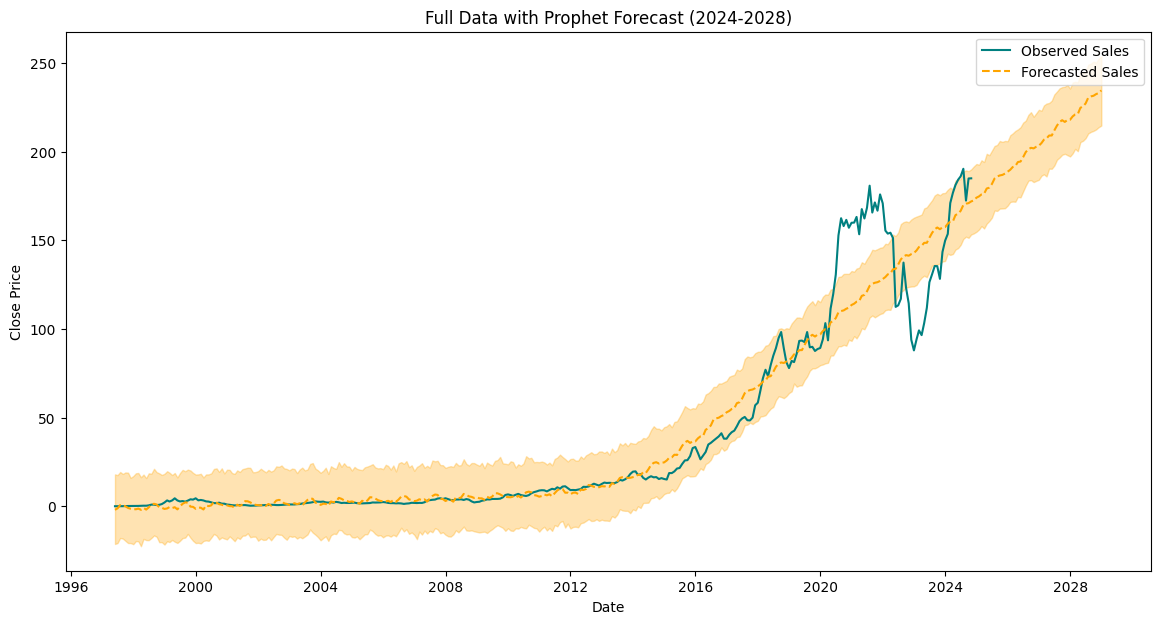

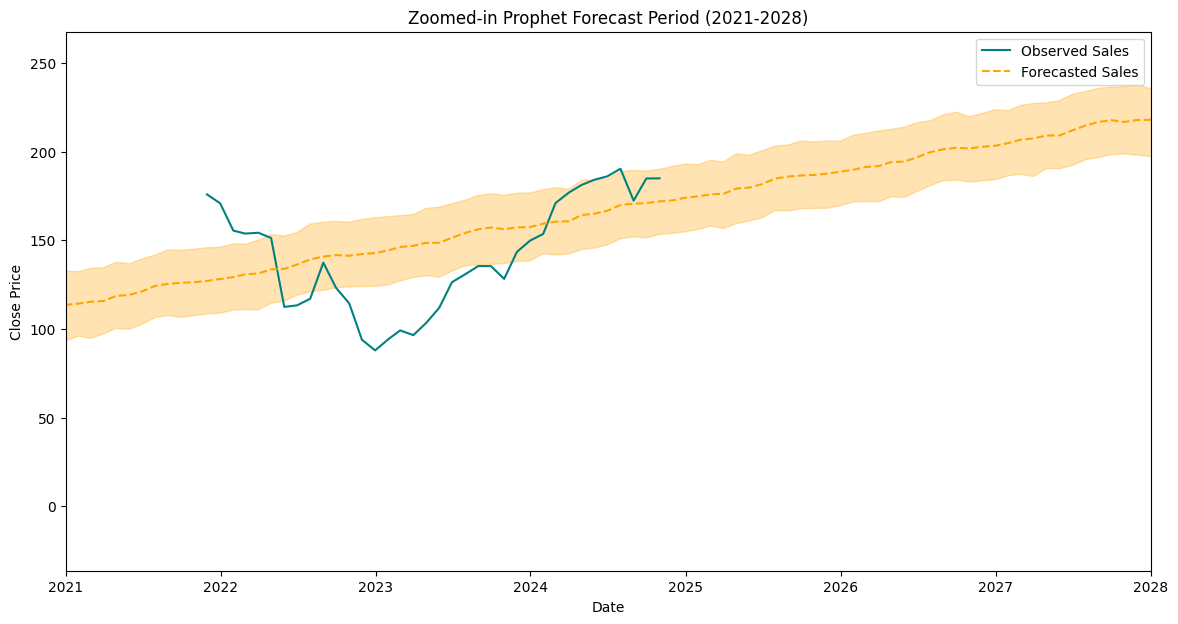

In [48]:
# Install Prophet package
!pip install prophet

# Import necessary libraries
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Prepare data for Prophet: Prophet requires a DataFrame with columns 'ds' and 'y'
df_prophet = df_monthly.reset_index()
df_prophet.columns = ['ds', 'y']  # Prophet expects the date column to be named 'ds' and the values column to be 'y'

# Split the data into training and test sets
train_data = df_prophet[df_prophet['ds'] < '2024-01-01']
test_data = df_prophet[df_prophet['ds'] >= '2024-01-01']

# Initialize and fit the Prophet model
prophet_model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
prophet_model.fit(train_data)

# Make future dataframe for prediction up to the end of 2028
future_dates = prophet_model.make_future_dataframe(periods=60, freq='M')  # 60 months into the future
prophet_forecast = prophet_model.predict(future_dates)

# Plot 1: Full data with extended forecast
plt.figure(figsize=(14, 7))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Observed Sales', color='teal')
plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'], color='orange', linestyle='--', label='Forecasted Sales')
plt.fill_between(prophet_forecast['ds'],
                 prophet_forecast['yhat_lower'],
                 prophet_forecast['yhat_upper'],
                 color='orange', alpha=0.3)
plt.title('Full Data with Prophet Forecast (2024-2028)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Plot 2: Zoomed-in view of the forecast period only
plt.figure(figsize=(14, 7))
plt.plot(df_prophet['ds'][-36:], df_prophet['y'][-36:], label='Observed Sales', color='teal')  # Show recent data only
plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'], color='orange', linestyle='--', label='Forecasted Sales')
plt.fill_between(prophet_forecast['ds'],
                 prophet_forecast['yhat_lower'],
                 prophet_forecast['yhat_upper'],
                 color='orange', alpha=0.3)
plt.xlim([pd.to_datetime('2021-01-01'), pd.to_datetime('2028-01-01')])  # Ensure the date limits are datetime objects
plt.title('Zoomed-in Prophet Forecast Period (2021-2028)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()
